# Import

In [69]:
import pandas as pd
from pandas_profiling import ProfileReport
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
import seaborn as sb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import StratifiedKFold

from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

# Functions

In [75]:
def fillna_mode(df, col):
    """
    Function fills NaN values in column of df with MODE value.
    :param col: Column to replace NaN with mode
    :param df: Dataframe with specified column
    """
    df.fillna({col : df[col].mode().iloc[0]}, inplace=True)

def fillna_group_mode(df, grp_col, col):
    """
    Function fills NaN values in column of df with MODE value computed for categories in group column.
    :param df: Dataframe with specified column
    :param grp_col: Column with categories to group by
    :param col: Column to replace NaN with mode
    """

    col_mode = df.groupby(grp_col)[col].agg(lambda x: pd.Series.mode(x)[0])
    df[col] = df[[grp_col, col]].apply(lambda elms: col_mode[elms[0]] if pd.isna(elms[1]) else elms[1], axis=1)

def show_boxplot(df, qual_col, y_col, showfliers=True):
    """
    Show boxplots for every qualitative value in specified column
    :param showfliers: parameter for show/hide outliers
    :param df: DataFrame
    :param qual_col: Column with qualitative values
    :param y_col: y variable for boxplot
    """
    n_unique = df[qual_col].nunique()
    fig, ax = plt.subplots(figsize = (1.5*n_unique, 10))
    sb.boxplot(x=qual_col, y=y_col, data=df, ax=ax, showfliers=showfliers, medianprops={'color':'red'})
    plt.xticks(rotation=45)
    ax.set_title(f'Boxplot for {col}')
    plt.show()

def show_clf_metrics(y_true, y_pred):
    print('precision_score=',precision_score(y_true, y_pred))
    print('recall_score=',   recall_score(y_true, y_pred))
    print('accuracy_score=', accuracy_score(y_true, y_pred))
    print('f1_score=',       f1_score(y_true, y_pred))

def preproc_data(df_in):
    """
    All-in-one function which contains code presented in the cells below.
    We can choose how to get preprocessed data in "Model training->Define preprocessed data" section.
    So after section "Data loading" you should choose a way for data preprocessing -
    via cells run in a chain or via this function
    """

    df_out = df_in.copy()

    # define columns with different kinds of features
    bin_text_cols = ['sex', 'car', 'car_type', 'foreign_passport']
    bin_cols = bin_text_cols + ['good_work']

    cat_text_cols = ['education']
    cat_cols = cat_text_cols + ['home_address', 'work_address', 'sna', 'first_time']
    qual_cols = bin_cols + cat_cols

    num_cols = ['age','decline_app_cnt','score_bki','income','bki_request_cnt','region_rating']

    # replace education NaN values with car_type's mode
    fillna_group_mode(df_out, 'car_type', 'education')

    # # some distribution are skewed to the left, let's use log function for them
    # for col in ['decline_app_cnt', 'income', 'bki_request_cnt']:
    #     df_train[col] = np.log(df_train[col]+1)

    # === Feature engineering ===

    # Add dummy columns for all categorical features
    df_out = pd.get_dummies(df_out, prefix=cat_cols, columns=cat_cols)

    # encode text binary features
    for col in bin_text_cols:
        df_out[col] = LabelEncoder().fit_transform(df_out[col])

    # all numeric features list for further appending
    all_num_cols = num_cols

    # date column
    df_out['app_date'] = pd.to_datetime(df_out['app_date'])

    # number of clients with same date of application
    clients_in_date = df_out.groupby('app_date')['client_id'].count()
    df_out['clients_in_date'] = df_out['app_date'].apply(lambda x: clients_in_date[x])
    all_num_cols.append('clients_in_date')

    # days from the first date
    first_date = df_out['app_date'].min()
    df_out['app_delay'] = df_out['app_date'].apply(lambda x: (x - first_date).days)
    all_num_cols.append('app_delay')

    # mean income by age
    mean_income_age = df_out.groupby('age')['income'].mean()
    df_out['mean_income_age'] = df_out['age'].apply(lambda x: mean_income_age[x])
    all_num_cols.append('mean_income_age')

    # max income by age
    max_income_age = df_out.groupby('age')['income'].max()
    df_out['max_income_age'] = df_out['age'].apply(lambda x: max_income_age[x])
    all_num_cols.append('max_income_age')

    # mean income by region
    mean_income_reg = df_out.groupby('region_rating')['income'].mean()
    df_out['mean_income_region'] = df_out['region_rating'].apply(lambda x: mean_income_reg[x])
    all_num_cols.append('mean_income_region')

    # max income by region
    max_income_reg = df_out.groupby('region_rating')['income'].max()
    df_out['max_income_region'] = df_out['region_rating'].apply(lambda x: max_income_reg[x])
    all_num_cols.append('max_income_region')

    # mean declines by age
    mean_declines_age = df_out.groupby('age')['decline_app_cnt'].mean()
    df_out['mean_declines_age'] = df_out['age'].apply(lambda x: mean_declines_age[x])
    all_num_cols.append('mean_declines_age')

    # scale all numeric feature via StandardScaler
    scaled_features = StandardScaler().fit_transform(df_out[all_num_cols].values)
    df_out[all_num_cols] = pd.DataFrame(scaled_features, index=df_out.index, columns=all_num_cols)

    # drop unneseccary columns
    df_out.drop(['client_id','app_date'], axis=1, inplace=True)

    return df_out

# Init

In [76]:
sb.set_style("darkgrid")

# fix random seed
SEED = 42

# fix requirements
!pip freeze > requirements.txt

# Data loading


In [77]:
DATA_DIR = './Data'

# all data available for training
train_data = pd.read_csv(DATA_DIR + '/train.csv')
train_data.info()
display(train_data.describe())

# test data
test_data = pd.read_csv(DATA_DIR + '/test.csv')
test_data.info()
display(test_data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

,client_id,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,default
count,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000
mean,55137.965094,39.280641,0.275749,0.164894,-1.904724,2.000339,56.725701,1.575509,2.496280,41099.775417,1.733330,2.765458,0.126994
std,31841.921168,11.520378,0.804272,0.371087,0.498231,2.252073,13.055717,0.527631,0.689818,46166.322400,1.123622,1.009463,0.332968
min,1.000000,21.000000,0.000000,0.000000,-3.624586,0.000000,20.000000,1.000000,1.000000,1000.000000,1.000000,1.000000,0.000000
25%,27440.500000,30.000000,0.000000,0.000000,-2.259534,0.000000,50.000000,1.000000,2.000000,20000.000000,1.000000,2.000000,0.000000
50%,55274.000000,37.000000,0.000000,0.000000,-1.920823,1.000000,50.000000,2.000000,3.000000,30000.000000,1.000000,3.000000,0.000000
75%,82758.500000,48.000000,0.000000,0.000000,-1.569831,3.000000,60.000000,2.000000,3.000000,48000.000000,2.000000,4.000000,0.000000
max,110147.000000,72.000000,33.000000,1.000000,0.199773,53.000000,80.000000,3.000000,3.000000,1000000.000000,4.000000,4.000000,1.000000


,client_id,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time
count,36349.000000,36349.000000,36349.000000,36349.000000,36349.000000,36349.000000,36349.000000,36349.000000,36349.000000,36349.000000,36349.000000,36349.000000
mean,54945.647473,39.186002,0.268040,0.166772,-1.904152,2.014471,56.802938,1.573798,2.501087,40835.755729,1.728053,2.765798
std,31706.052195,11.513258,0.788478,0.372777,0.501764,2.296789,13.086646,0.527428,0.683227,43802.180951,1.120686,1.011560
min,4.000000,21.000000,0.000000,0.000000,-3.574197,0.000000,20.000000,1.000000,1.000000,1000.000000,1.000000,1.000000
25%,27744.000000,30.000000,0.000000,0.000000,-2.261909,0.000000,50.000000,1.000000,2.000000,20000.000000,1.000000,2.000000
50%,54657.000000,37.000000,0.000000,0.000000,-1.920823,1.000000,50.000000,2.000000,3.000000,30000.000000,1.000000,3.000000
75%,82322.000000,48.000000,0.000000,0.000000,-1.563957,3.000000,60.000000,2.000000,3.000000,48000.000000,2.000000,4.000000
max,110148.000000,71.000000,30.000000,1.000000,0.188820,47.000000,80.000000,3.000000,3.000000,1000000.000000,4.000000,4.000000


# EDA

In [8]:
# let's try pandas profiling tool
profiling = ProfileReport(train_data)
profiling.to_file(outputfile='Reports/profiling.html')

TypeError: concat() got an unexpected keyword argument 'join_axes'

<AxesSubplot:xlabel='default', ylabel='count'>

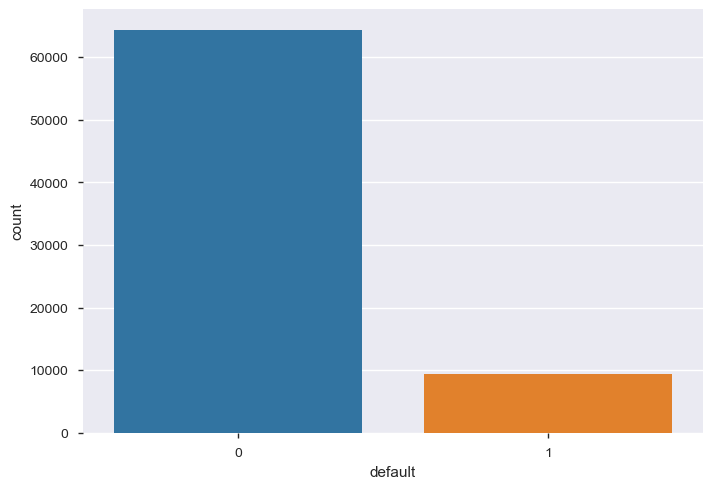

In [9]:
# check class balance for target variable
sb.countplot(x='default', data=train_data)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59039 entries, 19791 to 70504
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         59039 non-null  int64  
 1   app_date          59039 non-null  object 
 2   education         58794 non-null  object 
 3   sex               59039 non-null  object 
 4   age               59039 non-null  int64  
 5   car               59039 non-null  object 
 6   car_type          59039 non-null  object 
 7   decline_app_cnt   59039 non-null  int64  
 8   good_work         59039 non-null  int64  
 9   score_bki         59039 non-null  float64
 10  bki_request_cnt   59039 non-null  int64  
 11  region_rating     59039 non-null  int64  
 12  home_address      59039 non-null  int64  
 13  work_address      59039 non-null  int64  
 14  income            59039 non-null  int64  
 15  sna               59039 non-null  int64  
 16  first_time        59039 non-null  in

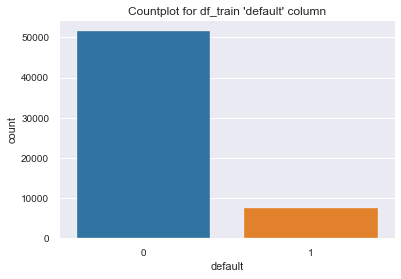

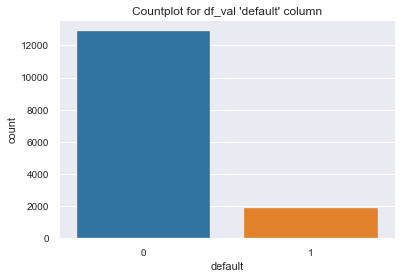

In [78]:
# we have unbalanced data, so split train data to train and validation datasets considering stratification
# and process them seperately to minimize validation data influence on train data 
df_train, df_val = train_test_split(train_data, test_size=0.2, random_state=SEED, stratify=train_data['default'])

df_train.info()
sb.countplot(x=df_train['default'])
plt.gca().set_title('Countplot for df_train \'default\' column')

df_val.info()
plt.figure()
sb.countplot(x=df_val['default'])
plt.gca().set_title('Countplot for df_val \'default\' column');

# make copy of our origin data for further analysis
df_train_orig = df_train.copy()
df_val_orig = df_val.copy()

In [19]:
# define columns with different kinds of features
bin_text_cols = ['sex', 'car', 'car_type', 'foreign_passport']
bin_cols = bin_text_cols + ['good_work']

cat_text_cols = ['education']
cat_cols = cat_text_cols + ['home_address', 'work_address', 'sna', 'first_time']
qual_cols = bin_cols + cat_cols

num_cols = ['age','decline_app_cnt','score_bki','income','bki_request_cnt','region_rating']

In [ ]:
# we have some missing values in education column
# to define our strategy for their substitution let's see what column is the best for 'education' grouping
# to replace missing values via group mode (not the mode computed over all dataset) There might be some benefits (in theory..:-/)

# temp dataset for analysis without missing values in 'education'
df_train_no_miss = df_train.dropna()

# for analysis we already need numbers, not text
# so encode qualitative columns text with numbers
for col in bin_text_cols + cat_text_cols:
    df_train_no_miss[col] = LabelEncoder().fit_transform(df_train_no_miss[col])

df_train_no_miss.head(10)

In [ ]:
# get feature importance among qualitative columns for 'education'
edu_mutual_info = pd.Series(mutual_info_classif(df_train_no_miss[set(qual_cols)-{'education'}], df_train_no_miss['education'],
                                                discrete_features =True), index = set(qual_cols)-{'education'})
edu_mutual_info.sort_values(inplace = True)
edu_mutual_info.plot(kind = 'barh')

In [17]:
sb.countplot(x="car_type", hue="education", data=df_train)

<AxesSubplot:title={'center':"Countplot for df_val 'default' column"}, xlabel='car_type', ylabel='count'>

In [ ]:
pd.crosstab(df_train.car_type, df_train.education, normalize='index')

In [ ]:
# we see that indeed mode of education depends on car_type
# so replace education NaN values with car_type's mode
fillna_group_mode(df_train, 'car_type', 'education')

df_train.info()
df_train['education'].value_counts()

## Numerical data analysis

In [21]:
for col in num_cols:
    sb.displot(df_train[col])

In [ ]:
# some distribution are skewed to the left, let's use log function for them
for col in ['decline_app_cnt', 'income', 'bki_request_cnt']:
    df_train[col] = np.log(df_train[col]+1)
    sb.displot(df_train[col])

Looks better but will compare no log/with log results later

In [ ]:
# calculate the correlation matrix
corr = df_train.dropna().corr()
display(corr)

# plot the heatmap
sb.heatmap(abs(corr), xticklabels=corr.columns, yticklabels=corr.columns)

Home address and work addres are exprectedly correlated, but there is no extreme multicollinearity that could be dangerous for logistic regression.

In [ ]:
for col in num_cols:
    show_boxplot(df_train, 'default', col)

In [ ]:
sb.countplot(x="good_work", hue="default", data=df_train)

In [ ]:
sb.histplot(data=df_train, x="age", hue="default")

plt.figure()
sb.histplot(data=df_train, x="region_rating", hue="default")

### Intermediate conclusions:
- those who older are generally more reliable debitor
- decline_app_cnt, bki_request and score_bki could be rather informative features for default predictions (positive "correlation" with default)
- income is generally lower for default clients
- region matters

There are also some "boxplot outliers", but taking into account context there is no strong evidence to consider they really are

## Features encoding

In [ ]:
df_train_enc = df_train.copy()

# encode text binary and categorical features
for col in bin_text_cols + cat_text_cols:
    df_train_enc[col] = LabelEncoder().fit_transform(df_train_enc[col])

df_train_enc.head(10)

## Numeric and qulitative feature importance

In [ ]:
plt.figure()
imp_num = pd.Series(f_classif(df_train[num_cols], df_train['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')


plt.figure()
imp_cat = pd.Series(mutual_info_classif(df_train_enc[bin_cols + cat_cols], df_train_enc['default'],
                                        discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

In [ ]:
# surprisingly it seems that good work indeed has virtually no influence on default..
pd.crosstab(df_train.good_work, df_train.default, normalize='index')

# Feature engineering

In [ ]:
# Add dummy columns for all categorical features
df_train = pd.get_dummies(df_train, prefix=cat_cols, columns=cat_cols)

# encode text binary features
for col in bin_text_cols:
    df_train[col] = LabelEncoder().fit_transform(df_train[col])

df_train

In [ ]:
# check decline_app_cnt dependence on age
train_data.groupby('age')['decline_app_cnt'].mean().plot()

In [ ]:
# all numeric features list for further appending
all_num_cols = num_cols

# date column
df_train['app_date'] = pd.to_datetime(df_train['app_date'])
df_train.info()

df_train['app_date'].hist(bins=100)
plt.xticks(rotation='vertical')

# number of clients with same date of application
clients_in_date = df_train.groupby('app_date')['client_id'].count()
df_train['clients_in_date'] = df_train['app_date'].apply(lambda x: clients_in_date[x])
all_num_cols.append('clients_in_date')

# days from the first date
first_date = df_train['app_date'].min()
df_train['app_delay'] = df_train['app_date'].apply(lambda x: (x - first_date).days)
all_num_cols.append('app_delay')

# mean income by age
mean_income_age = df_train.groupby('age')['income'].mean()
df_train['mean_income_age'] = df_train['age'].apply(lambda x: mean_income_age[x])
all_num_cols.append('mean_income_age')

# max income by age
max_income_age = df_train.groupby('age')['income'].max()
df_train['max_income_age'] = df_train['age'].apply(lambda x: max_income_age[x])
all_num_cols.append('max_income_age')

# mean income by region
mean_income_reg = df_train.groupby('region_rating')['income'].mean()
df_train['mean_income_region'] = df_train['region_rating'].apply(lambda x: mean_income_reg[x])
all_num_cols.append('mean_income_region')

# max income by region
max_income_reg = df_train.groupby('region_rating')['income'].max()
df_train['max_income_region'] = df_train['region_rating'].apply(lambda x: max_income_reg[x])
all_num_cols.append('max_income_region')

# mean declines by age
mean_declines_age = df_train.groupby('age')['decline_app_cnt'].mean()
df_train['mean_declines_age'] = df_train['age'].apply(lambda x: mean_declines_age[x])
all_num_cols.append('mean_declines_age')

df_train

# Scaling

In [ ]:
# scale all numeric feature via StandardScaler
scaled_features = StandardScaler().fit_transform(df_train[all_num_cols].values)
df_train[all_num_cols] = pd.DataFrame(scaled_features, index=df_train.index, columns=all_num_cols)
df_train

# Preprocessing for training

In [ ]:
# drop unneseccary columns
df_train.drop(['client_id','app_date'], axis=1, inplace=True)

### Define preprocessed data (no need to use all-in-one preproc_data() function if df_train is already preprocessed in cells above)

In [79]:
df_train = preproc_data(df_train_orig)
df_train.info()
display(df_train)

df_val = preproc_data(df_val_orig)
df_val.info()
display(df_val)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59039 entries, 19791 to 70504
Data columns (total 38 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   sex                 59039 non-null  int32  
 1   age                 59039 non-null  float64
 2   car                 59039 non-null  int32  
 3   car_type            59039 non-null  int32  
 4   decline_app_cnt     59039 non-null  float64
 5   good_work           59039 non-null  int64  
 6   score_bki           59039 non-null  float64
 7   bki_request_cnt     59039 non-null  float64
 8   region_rating       59039 non-null  float64
 9   income              59039 non-null  float64
 10  foreign_passport    59039 non-null  int32  
 11  default             59039 non-null  int64  
 12  education_ACD       59039 non-null  uint8  
 13  education_GRD       59039 non-null  uint8  
 14  education_PGR       59039 non-null  uint8  
 15  education_SCH       59039 non-null  uint8  
 16  

,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,income,...,first_time_2,first_time_3,first_time_4,clients_in_date,app_delay,mean_income_age,max_income_age,mean_income_region,max_income_region,mean_declines_age
19791,0,0.842954,0,0,-0.340320,1,1.744689,0.445309,-0.516709,0.406796,...,0,1,0,1.106612,0.251588,0.458036,0.066985,-0.594895,0.081019,-0.635411
49335,0,-1.327282,0,0,-0.340320,0,0.854127,-0.886130,-0.516709,-0.455227,...,0,1,0,-0.490633,0.407326,-1.148992,-1.337207,-0.594895,0.081019,1.562949
41747,1,-1.327282,0,0,-0.340320,0,-0.952944,-0.442317,1.783778,0.083538,...,1,0,0,-0.247915,-0.527105,-1.148992,-1.337207,1.944831,0.081019,1.562949
62167,0,-0.459188,0,0,-0.340320,0,-1.814219,-0.442317,-0.516709,-0.239721,...,1,0,0,-0.114811,1.435200,0.293828,-0.334213,-0.594895,0.081019,-0.315049
63663,0,1.624239,0,0,0.892477,0,-1.515579,-0.886130,-1.283538,-0.239721,...,0,1,0,0.605515,0.563065,-1.597335,-1.136608,-0.717500,0.081019,-0.884710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32943,0,-1.414091,0,0,0.892477,1,1.867239,0.001496,-0.516709,-0.562980,...,0,1,0,0.245352,0.749951,-1.455321,-2.019243,-0.594895,0.081019,2.278833
22747,0,0.582526,1,0,-0.340320,0,0.260967,-0.442317,-1.283538,-0.390575,...,0,0,0,1.427627,0.500769,0.991923,0.869380,-0.717500,0.081019,-0.523497
19710,1,1.277001,0,0,-0.340320,0,0.178073,0.001496,-1.283538,-0.498328,...,0,1,0,0.738619,-0.963172,-0.152754,-0.735410,-0.717500,0.081019,-0.753932
13023,1,-0.545997,0,0,0.892477,0,-0.485557,0.889121,-0.516709,-0.239721,...,0,0,0,-0.247915,-0.527105,0.758373,-0.936009,-0.594895,0.081019,0.354919


,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,income,...,first_time_2,first_time_3,first_time_4,clients_in_date,app_delay,mean_income_age,max_income_age,mean_income_region,max_income_region,mean_declines_age
60889,1,0.065537,1,1,-0.35374,0,-0.184022,-0.896666,1.778462,0.420187,...,0,0,1,0.070732,1.414181,0.190484,-0.411495,1.875006,-1.298540,-0.837091
46372,1,0.239096,1,1,-0.35374,1,-1.247441,0.883160,1.778462,2.410995,...,0,0,1,0.283843,1.165609,0.586638,-0.288503,1.875006,-1.298540,0.031893
42779,1,-0.108021,1,1,-0.35374,0,0.126356,0.438204,1.778462,0.088386,...,0,0,1,-0.020602,-0.419035,1.451953,1.433391,1.875006,-1.298540,-0.024722
40843,1,-0.455139,0,0,-0.35374,0,1.324130,-0.006753,1.015976,0.420187,...,0,0,1,0.588288,0.761680,1.102892,2.253341,1.531960,-1.298540,-0.636549
7022,0,1.714344,0,0,-0.35374,0,-0.439125,-0.451709,-0.508996,-0.537612,...,0,1,0,0.923178,0.047037,-2.092239,-1.149450,-0.561834,0.494253,-0.717519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9297,1,2.235020,1,0,-0.35374,1,0.303302,-0.006753,-0.508996,-0.066455,...,0,1,0,1.440734,0.419894,-2.131510,-1.026457,-0.561834,0.494253,-0.936720
49128,0,-0.715477,0,0,-0.35374,0,0.589462,-0.896666,1.778462,-0.132815,...,0,0,1,-2.364827,-1.786179,0.723468,1.433391,1.875006,-1.298540,0.086971
9380,0,-0.194801,0,0,-0.35374,0,-0.749145,-0.451709,-0.508996,-0.354016,...,0,0,0,-0.568602,0.202394,0.831190,-0.206508,-0.561834,0.494253,-0.130687
7799,0,1.540785,0,0,-0.35374,0,-0.129511,-0.006753,-0.508996,-0.630517,...,0,0,1,0.679622,1.320966,-0.090216,1.023417,-0.561834,0.494253,-1.518421


# Model training

In [80]:
X_train = df_train.drop(['default'], axis = 1).values
y_train = df_train['default'].values

X_val = df_val.drop(['default'], axis = 1).values
y_val = df_val['default'].values

precision_score= 0.46511627906976744
recall_score= 0.032017075773746
accuracy_score= 0.8724254742547426
f1_score= 0.059910134797803286


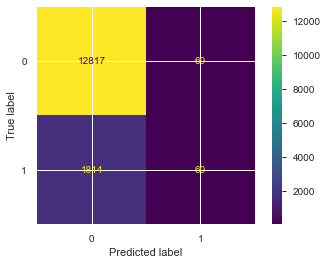

In [81]:
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_val)

show_clf_metrics(y_val, y_pred)
plot_confusion_matrix(clf, X_val, y_val)

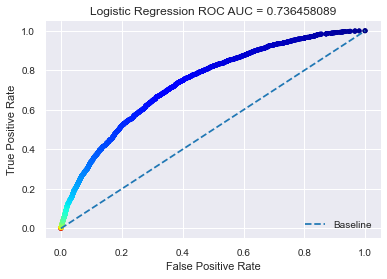

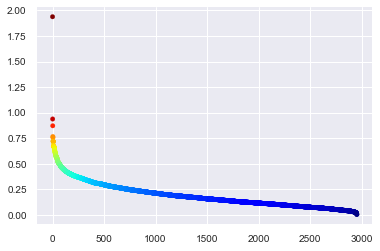

In [82]:
probs = clf.predict_proba(X_val)[:,1]

fpr, tpr, threshold = roc_curve(y_val, probs)
roc_auc = roc_auc_score(y_val, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
# plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.9f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')

# idxs = np.where((0.0 < threshold) & (threshold < 0.3))
# print(idxs)
# plt.plot(fpr[idxs], tpr[idxs], marker='o', markersize=5, linestyle='', c=colors)

colors = plt.cm.jet(threshold)

plt.scatter(fpr, tpr, marker='o', s=20, c=colors)

plt.show()

plt.figure()
plt.scatter(range(0,len(threshold)), threshold, marker='o', s=20, c=colors)

Experiments with hyperparameters

In [83]:
# regularization parameters
penalty = ['l1', 'l2']
C = np.logspace(-2, 2, 5)

hyperparameters = dict(C=C, penalty=penalty)

skf = StratifiedKFold(n_splits=5, shuffle = True, random_state = SEED)
cv = skf.split(X_train, y_train)

clf = LogisticRegression(max_iter=1000, solver='liblinear')
clf.fit(X_train, y_train)

clf = GridSearchCV(clf, hyperparameters, cv=cv, scoring='roc_auc', verbose=10, n_jobs=-1)

grid_search_model = clf.fit(X_train, y_train)

# View best hyperparameters
print('Best Penalty:',  grid_search_model.best_estimator_.get_params()['penalty'])
print('Best C:',        grid_search_model.best_estimator_.get_params()['C'])
print('Best score:',    grid_search_model.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Penalty: l2
Best C: 0.1
Best score: 0.7319499711214363


In [21]:
# check grid search best_estimator_ on validation set
probs = grid_search_model.best_estimator_.predict_proba(X_val)[:,1]

roc_auc = roc_auc_score(y_val, probs)
print('roc_auc for best grid_search_model:', roc_auc)

roc_auc for best grid_search_model: 0.7397101517933058


Grid search estimator has a bit higher roc_auc score on validation set

## Using more powerfull model
### XGBoost with RandomizedSearchCV

In [84]:
# try more powerfull model
skf = StratifiedKFold(n_splits=5, shuffle = True, random_state = SEED)
cv = skf.split(X_train, y_train)

xgb = XGBClassifier(learning_rate=0.025, n_estimators=700, objective='binary:logistic', silent=True, nthread=-1)

rnd_search_params = {
                    'min_child_weight': [1, 5, 10],
                    'gamma': [0.5, 1, 1.5, 2, 5],
                    'subsample': [0.6, 0.8, 1.0],
                    'colsample_bytree': [0.6, 0.8, 1.0],
                    'max_depth': [3, 4, 5]
                    }
random_search_model = RandomizedSearchCV(xgb, param_distributions=rnd_search_params, n_iter=5, scoring='roc_auc', 
                                    n_jobs=-1, cv=cv, verbose=3, random_state=SEED)

random_search_model.fit(X_train, y_train)

print('Random search model results:', random_search_model.cv_results_)

# check random_search best_estimator_ on validation set
probs = random_search_model.best_estimator_.predict_proba(X_val)[:,1]

roc_auc = roc_auc_score(y_val, probs)
print('roc_auc for best random_search_model:', roc_auc)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[02:53:55] WARNING: ..\src\learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:53:55] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Random search model results: {'mean_fit_time': array([44.6622025 , 30.74061928, 33.17570996, 31.69048119, 28.07853708]), 'std_fit_time': array([0.24264104, 0.36251084, 0.80054778, 2.62269945, 6.57746228]), 'mean_score_time': array([0.03590431, 0.02972074, 0.02912216, 0.02732706, 0.02912216]), 'std_score_time': array([0.00244295, 0.00193405, 0.00171565, 0.00205

C:\ProgramData\Anaconda3\envs\TestProject\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [45]:
X_train.shape

(59039, 37)

In [48]:
# we have best results on validation set for this model
# so train it on all data and predict for test set
X_train_all = np.vstack((X_train, X_val))
y_train_all = np.vstack((y_train[:,np.newaxis], y_val[:,np.newaxis]))

print('X_train_all.shape=', X_train_all.shape)
print('y_train_all.shape=', y_train_all.shape)

X_train_all.shape= (73799, 37)
y_train_all.shape= (73799, 1)


In [50]:
skf = StratifiedKFold(n_splits=5, shuffle = True, random_state = SEED)
cv_all = skf.split(X_train_all, y_train_all)

final_model = RandomizedSearchCV(xgb, param_distributions=rnd_search_params, n_iter=5, scoring='roc_auc', 
                                    n_jobs=-1, cv=cv_all, verbose=3, random_state=SEED)
final_model.fit(X_train_all, y_train_all)

print('Final model results:', final_model.cv_results_)

# check one more time on validation set
probs = final_model.best_estimator_.predict_proba(X_val)

roc_auc = roc_auc_score(y_val, probs[:,1])
print('roc_auc for final model on validation set (NB! included in train set):', roc_auc)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[02:30:12] WARNING: ..\src\learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:30:12] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Final model results: {'mean_fit_time': array([40.73948913, 27.85293894, 29.62819381, 28.66935744, 25.35302267]), 'std_fit_time': array([0.26870086, 0.23791428, 0.63895969, 2.3485606 , 5.77387177]), 'mean_score_time': array([0.04428201, 0.0375    , 0.03590417, 0.03131628, 0.03530588]), 'std_score_time': array([0.00755864, 0.00272022, 0.0038367 , 0.00299869, 0.0

C:\ProgramData\Anaconda3\envs\TestProject\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\TestProject\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


# Submission

In [85]:
df_test = preproc_data(test_data)

X_test = df_test.values
probs_test = final_model.best_estimator_.predict_proba(X_test)

df_sub = pd.DataFrame(data={'client_id': test_data['client_id'], 'default': probs_test})
df_sub

,client_id,default
0,74835,0.031493
1,17527,0.243730
2,75683,0.066114
3,26883,0.077412
4,28862,0.019687
...,...,...
36344,83775,0.396786
36345,106254,0.022831
36346,81852,0.262898
36347,1971,0.261885


In [88]:
df_sub.to_csv('submission.csv', index=False)